In [1]:
import cv2
import colorsys
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib import font_manager
from scipy.spatial.distance import jensenshannon


In [2]:
def get_correlation_df(xdf, ydf):
    xdf = xdf.loc[list(ydf.index)]  # make sure that the indexes match
    corr_matrix = np.empty((len(xdf.columns), len(ydf.columns)))
    for i, col1 in enumerate(xdf.columns):
        for j, col2 in enumerate(ydf.columns):
            corr, _ = pearsonr(xdf[col1], ydf[col2])
            corr_matrix[i, j] = corr

    corr_df = pd.DataFrame(data=corr_matrix,
                           index=xdf.columns,
                           columns=ydf.columns).T
    return corr_df


def generate_random_colors(num_colors, hue_range=(0, 1), saturation=0.5, lightness=0.65, min_distance=0.05, seed=None):
    colors = []
    hue_list = []
    if seed:
        np.random.seed(seed)
    else:
        np.random.seed(42)
    while len(colors) < num_colors:
        # generate a random hue value within the specified range
        hue = np.random.uniform(hue_range[0], hue_range[1])

        # check if the hue is far enough away from the previous hue
        if len(hue_list) == 0 or all(abs(hue - h) > min_distance for h in hue_list):
            hue_list.append(hue)
            saturation = saturation
            lightness = lightness
            rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
            hex_code = '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
            colors.append(hex_code)
    return colors


def plot_factors(adata, compartment_df):
    comp_names = compartment_df.columns
    adata.obs[comp_names] = compartment_df
    with mpl.rc_context({'figure.figsize': (4, 4), 'axes.facecolor': 'black'}):

        # select one section correctly subsetting histology image data
        sc.pl.spatial(adata,
                      cmap='magma',
                      color=comp_names,
                      ncols=6,
                      size=1, img_key='hires',
                      alpha_img=0.4,
                      # vmin=0, vmax='p99.2',
                      show=False
                      )
        plt.suptitle(method, fontsize=30)
        plt.tight_layout()
        plt.show()


def segment_tissue(img, scale=1.0, l=20, h=30):

    def detect_contour(img, low, high):
        img = img * 255
        img = np.uint8(img)
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, low, high)
        edges = cv2.dilate(edges, None)
        edges = cv2.erode(edges, None)
        cnt_info = []
        cnts, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for c in cnts:
            cnt_info.append((c, cv2.isContourConvex(c), cv2.contourArea(c)))
        cnt_info = sorted(cnt_info, key=lambda c: c[2], reverse=True)
        cnt = cnt_info[0][0]
        return cnt


    def scale_contour(cnt, scale):
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cnt_norm = cnt - [cx, cy]
        cnt_scaled = cnt_norm * scale
        cnt_scaled = cnt_scaled + [cx, cy]
        cnt_scaled = cnt_scaled.astype(np.int32)
        return cnt_scaled

    cnt = detect_contour(img, l, h)
    cnt_enlarged = scale_contour(cnt, scale)
    binary = np.zeros(img.shape[0:2])
    cv2.drawContours(binary, [cnt_enlarged], -1, 1, thickness=-1)
    img[binary == 0] = 1
    return img, binary, cnt_enlarged


/home/demeter_turos/anaconda3/envs/BearCovid39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


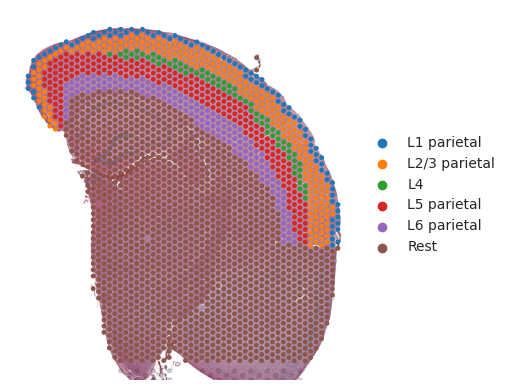

In [3]:
data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/article/IV_mouse_brain/data/'

csvs = glob(data_path + '*comps.csv')
method_suffix = {'chr': 'chrysalis', 'stagate': 'STAGATE', 'graphst': 'GraphST',
                 'mephisto': 'MEFISTO', 'nsf': 'NSF', 'spatialpca': 'SpatialPCA'}

adata = sc.read_h5ad(data_path + 'chr_28_annotated.h5ad')

# segment image for the looks
img = adata.uns['spatial']['Visium_FFPE_Mouse_Brain']['images']['hires']
img, _, _ = segment_tissue(img)
adata.uns['spatial']['Visium_FFPE_Mouse_Brain']['images']['hires'] = img

# one-hot encoding
selected_layers = ['L1 parietal', 'L2/3 parietal', 'L4', 'L5 parietal', 'L6 parietal']
annot_df = pd.get_dummies(adata.obs['annotation'])
annot_df = annot_df[selected_layers]

# plot annotations
plt.rcParams['svg.fonttype'] = 'none'
adata.obs['annotation_plot'] = [x if x in selected_layers else 'Rest' for x in adata.obs['annotation']]
fig, ax = plt.subplots(1, 1, figsize=(7*0.8, 5*0.8))
sc.pl.spatial(adata, color='annotation_plot', ax=ax, size=1.2, show=False)
ax.axis('off')
ax.set_title(None)
plt.tight_layout()
plt.show()


In [4]:
# correlation with tissue zones
combination_dict = {}
method_df = pd.DataFrame()
for csv in csvs:
    compartment_df = pd.read_csv(csv, index_col=0)
    method = csv.split('/')[-1].split('_')[0]
    method = method_suffix[method]

    corr_df = get_correlation_df(annot_df, compartment_df)

    max_corr_id = corr_df.idxmax(axis=0)

    scaled_df = compartment_df.copy()
    for c in scaled_df.columns:
        x = scaled_df[c]
        x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
        scaled_df[c] = x_scaled

    combined_df = pd.concat([adata.obs['annotation'], scaled_df[max_corr_id]], axis=1)
    combined_df['method'] = method

    combined_df = combined_df[combined_df['annotation'].isin(selected_layers)]
    combined_df['annotation'] = combined_df['annotation'].cat.set_categories(selected_layers)

    long_df = pd.melt(combined_df, value_vars=max_corr_id, id_vars=['annotation', 'method'])
    long_df['comp_id'] = long_df['method'] + long_df['variable']

    # add some names to the compartments to see where they should have maximum value
    layer_id = []
    layer_map = {k: v for k, v in zip(max_corr_id.values, max_corr_id.index)}
    combinations = {v.split(' ')[0]: k for k, v in zip(max_corr_id.values, max_corr_id.index)}
    combination_dict[method] = combinations
    for x in long_df['variable']:
        layer_id.append(layer_map[x])
    long_df['layer_id'] = layer_id

    method_df = pd.concat([method_df, long_df], axis=0, ignore_index=True)

method_df['layer_id'] = [x.split(' ')[0] for x in method_df['layer_id']]


/home/demeter_turos/anaconda3/envs/BearCovid39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


/tmp/ipykernel_2203/2608112096.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(mdf, x='annotation', y='value', hue='layer_id', ax=ax,
/tmp/ipykernel_2203/2608112096.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_2203/2608112096.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(mdf, x='annotation', y='value', hue='layer_id', ax=ax,
/tmp/ipykernel_2203/2608112096.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_2203/26

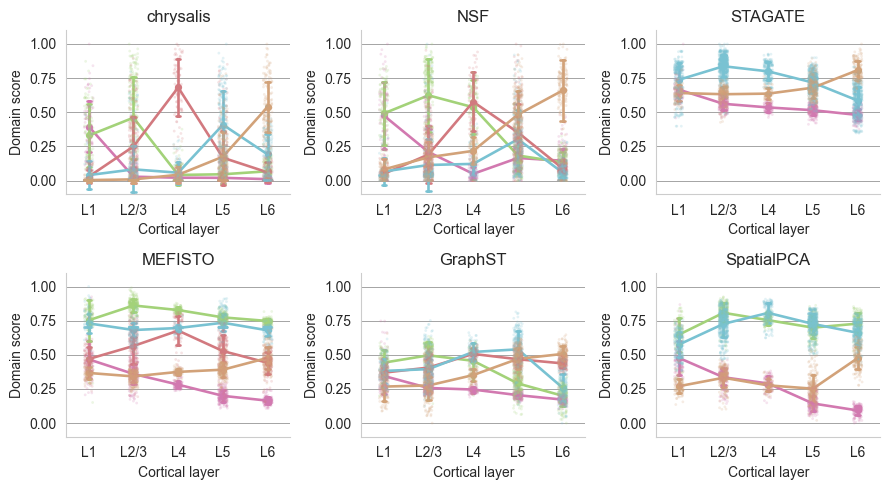

In [5]:
hexcodes = generate_random_colors(num_colors=28, min_distance=1 / 28 * 0.5, seed=69)
hexcodes = [hexcodes[x] for x in [26, 5, 20, 15, 11]]
hexcodes = {k: v for k, v in zip(['L1', 'L2/3', 'L4', 'L5', 'L6', ], hexcodes)}

method_df['annotation'] = [x.split(' ')[0] for x in method_df['annotation']]
method_df['annotation'] = method_df['annotation'].astype('category')
method_df['annotation'] = method_df['annotation'].cat.set_categories(np.unique(method_df['annotation']))

font_files = mpl.font_manager.findSystemFonts()
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['svg.fonttype'] = 'none'
fig, axs = plt.subplots(2, 3, figsize=(9, 5))
axs = axs.flatten()

for m, ax in zip(['chrysalis', 'NSF', 'STAGATE', 'MEFISTO', 'GraphST', 'SpatialPCA'], axs):
    mdf = method_df[method_df['method'] == m]

    sns.pointplot(mdf, x='annotation', y='value', hue='layer_id', ax=ax,
                 errorbar='sd', capsize=0.10, palette=hexcodes, scale=0.7)
    sns.stripplot(mdf, x='annotation', y='value', hue='layer_id', ax=ax, s=2, alpha=0.2,
                  palette=hexcodes, legend=False, rasterized=True)
    ax.grid(axis='y', linestyle='-', linewidth='0.5', color='grey')
    ax.set_axisbelow(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(loc = 'upper right', title='')
    ax.set_xlabel('Cortical layer')
    ax.set_ylabel('Domain score')
    ax.set_title(m)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim((-0.1, 1.1))
    ax.get_legend().set_visible(False)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2203/4132816448.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  pointplot = sns.pointplot(mdf, y='annotation', x='value', hue='layer_id', ax=axs[i],
/tmp/ipykernel_2203/4132816448.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  pointplot = sns.pointplot(mdf, y='annotation', x='value', hue='layer_id', ax=axs[i],
/tmp/ipykernel_2203/4132816448.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  pointplot = sns.pointplot(mdf, y='annotation', x='value', hue='layer_id', 

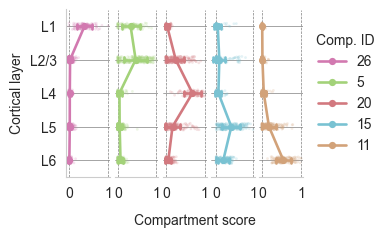

In [6]:
font_files = mpl.font_manager.findSystemFonts()
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

fig, axs = plt.subplots(1, 5, figsize=(4, 2.5), sharey=True)

m = 'chrysalis'
ddf = method_df[method_df['method'] == m]

all_handles = []
all_labels = []

for i, id in enumerate(['L1', 'L2/3', 'L4', 'L5', 'L6']):
    mdf = ddf[ddf['layer_id'] == id]

    pointplot = sns.pointplot(mdf, y='annotation', x='value', hue='layer_id', ax=axs[i],
                              errorbar='sd', capsize=0.15, palette=hexcodes, scale=0.7)

    stripplot = sns.stripplot(mdf, y='annotation', x='value', hue='layer_id', ax=axs[i], s=2, alpha=0.2,
                              palette=hexcodes, legend=False, rasterized=True)

    handles, labels = axs[i].get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

    axs[i].grid(axis='y', linestyle='-', linewidth='0.5', color='grey')
    axs[i].grid(axis='x', linestyle='--', linewidth='0.5', color='grey')
    axs[i].set_axisbelow(True)
    axs[i].set_xlabel(None)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

    axs[i].set_ylabel(None)

axs[0].set_ylabel('Cortical layer')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)
axs[0].spines['left'].set_visible(True)

unique_handles_labels = dict(zip(all_labels, all_handles))
sorted_labels = list(unique_handles_labels.keys())
sorted_handles = [unique_handles_labels[label] for label in sorted_labels]

for ax in axs:
    ax.get_legend().remove()

legend = axs[-1].legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Comp. ID')
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

new_labels = ['26', '5', '20', '15', '11']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
fig.supxlabel('Compartment score', fontsize=10, y=0.07)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()


In [7]:
# jensen-shannon distance
np.random.seed(42)
# iterate over methods
m_dict = {}
for m in np.unique(method_df['method']):
    subs_df = method_df[method_df['method'] == m]
    subs_df = subs_df.dropna()
    subs_df['annotation'] = [x.split(' ')[0] for x in subs_df['annotation']]  # match the annotation column to layer_id

    # iterate over compartments that are associated to a specific layer
    layer_dict = {}
    combinations = combination_dict[m]
    for l, comp in combinations.items():
        ldf = subs_df[subs_df['comp_id'] == (m + str(comp))]
        draws = []
        neg_vals = ldf[ldf['annotation'] != l]['value']
        pos_vals = ldf[ldf['annotation'] == l]['value']
        for i in range(1000):
            neg_vals = np.random.choice(neg_vals, size=len(pos_vals), replace=False)
            draws.append(jensenshannon(neg_vals, list(pos_vals)))
        layer_dict[l] = np.mean(draws)
    m_dict[m] = layer_dict

jensen_df = pd.DataFrame(m_dict)


/tmp/ipykernel_2203/2789654683.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_2203/2789654683.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_2203/2789654683.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_2203/2789654683.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_2203/2789654683.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


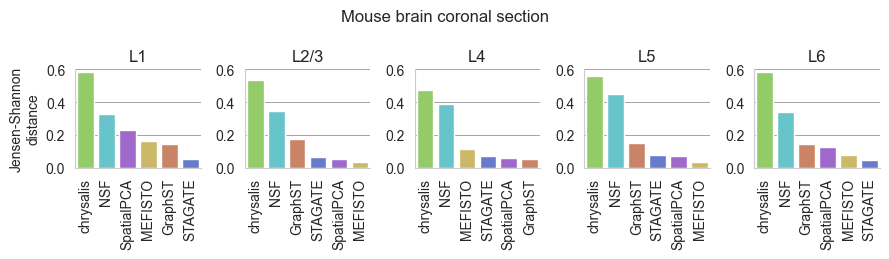

In [8]:
color_dict = {
    'chrysalis': '#91db57',
    'NSF': '#57d3db',
    'STAGATE': '#5770db',
    'MEFISTO': '#dbc257',
    'SpatialPCA': '#a157db',
    'GraphST': '#db7c57',
}

font_files = mpl.font_manager.findSystemFonts()
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

fig, axs = plt.subplots(1, 5, figsize=(9, 2.6))
axs[0].set_ylabel('Jensen-Shannon\ndistance')
for i, ax in zip(range(len(jensen_df)), axs):
    jensen_layer = jensen_df.iloc[i, :]
    jensen_layer = jensen_layer.sort_values(ascending=False)
    ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
    ax.set_axisbelow(True)
    sns.barplot(pd.DataFrame(jensen_layer).T, palette=color_dict, ax=ax)
    ax.set_title(jensen_layer.name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim([0.0, 0.6])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.suptitle('Mouse brain coronal section')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()
